# Libraries

##  Remove warnings

In [1]:
import warnings
warnings.filterwarnings("ignore")

## Import libraries

In [2]:
# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Basic libraries
#
import time
import pandas    as pd
import numpy     as np
from   tqdm      import tqdm


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Visualization library
#
import matplotlib.pyplot   as plt 


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Sklearn library
#
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
# Tensorflow library
#
import tensorflow 
from   tensorflow.keras.metrics                 import *
from   tensorflow.keras.optimizers              import *
from   tensorflow.keras.callbacks               import EarlyStopping
from   tensorflow.keras.callbacks               import ModelCheckpoint
from   tensorflow.keras.callbacks               import ReduceLROnPlateau


# =-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
#
# User libraries
#
from utils.PerformanceMetrics import RegressionEvaluation
from utils.plot_scatter       import *

# Parameters

## CUDA

In [3]:
try:
    gpus = tensorflow.config.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tensorflow.config.experimental.set_memory_growth(gpu, True)

            logical_gpus = tensorflow.config.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

        except RuntimeError as e:

            # Memory growth must be set before GPUs have been initialized
            print(e)
except:
    print('[INFO] Not GPU found')

## Data handling parameters

In [4]:
# Parameters
#
filename        = '../metadata/7-kanal-1.csv'
#
Transformation  = True
Scaling         = 'Standard'

## Neural networks parameters

In [5]:
Lag        =   12
Horizon    =    4
#
epochs     =  200
batch_size =   32

# Data handling

## Import data


In [6]:
# Start timer
#
start = time.time()

# Load data
#
df = pd.read_csv( filename )

print('[INFO] Data imported')
print('[INFO] Time: %.2f seconds' % (time.time() - start))

df.head(3)

[INFO] Data imported
[INFO] Time: 0.34 seconds


,Date,Temperature,Humidity,PM2.5,PM10,NO2,CO
0,2022-02-19 00:00:09,-2.4,86.0,2.7,4.9,212.0,263.0
1,2022-02-19 00:00:25,-2.4,86.0,2.7,7.6,209.0,261.0
2,2022-02-19 00:00:41,-2.4,86.0,2.6,7.3,204.0,258.0


## Preprocess data

### Set index

In [7]:
# Convert Date to 'datetime64'
#
df['Date'] = df['Date'].astype('datetime64')

# Set index
#
df.set_index('Date', inplace=True)


df = df.resample('5min').mean().interpolate()
df = pd.DataFrame( df[['Temperature', 'Humidity', 'PM10', 'PM2.5']] )
# df = pd.DataFrame( df[['PM10', 'PM2.5']] )
# df = pd.DataFrame( df[ 'PM2.5' ] )


df.head(3)

,Temperature,Humidity,PM10,PM2.5
Date,,,,
2022-02-19 00:00:00,-2.415789,86.0,4.926316,2.457895
2022-02-19 00:05:00,-2.421053,86.0,5.689474,2.494737
2022-02-19 00:10:00,-2.436842,86.0,5.689474,2.494737


In [8]:
targetSeries = df.columns[-1]

### Include MA-based features

In [9]:
# df['MA6']  = df[ targetSeries ].rolling(6).mean()
# df['MA12'] = df[ targetSeries ].rolling(12).mean()

In [10]:
idx = int( df.shape[0] * 0.8 )

df_train = df[ :idx ].dropna()
df_test  = df[ idx: ].dropna()

### Visualization

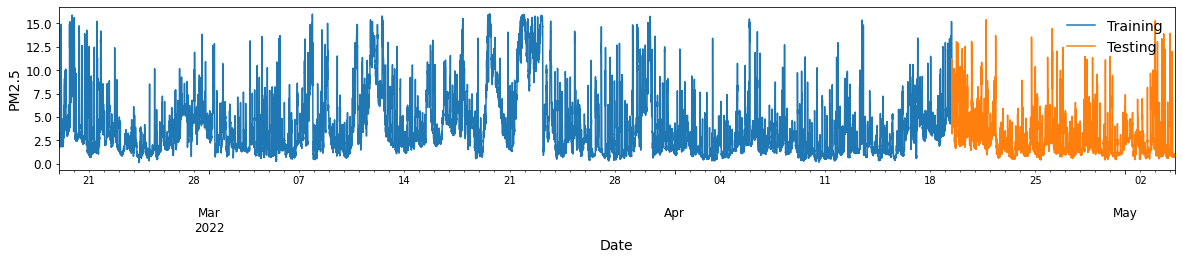

In [11]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(20, 3) )

df_train[ targetSeries ].plot(ax=ax, color='tab:blue' )
df_test[ targetSeries ].plot(ax=ax,  color='tab:orange')

plt.legend(['Training', 'Testing'], frameon = False, fontsize = 14)
plt.ylabel(targetSeries, size = 14)
plt.xlabel('Date', size = 14);
plt.xticks(size = 12);
plt.yticks(size = 12);

### Fixing Lag

In [12]:
df_test = pd.concat([df_train.iloc[-Lag:], df_test])

## Preprocessing

## Data Transformation

In [13]:
if (Transformation == True):
    
    print('[INFO] Data transformation applied')
    
    VALUE = max(df.min().min(), 1.0)
    
    df_train = np.log( df_train + VALUE)
    df_test  = np.log( df_test  + VALUE)
    
else:
    print('[INFO] No data transformation applied.')  

[INFO] Data transformation applied


In [14]:
if (Scaling == 'MinMax'):
    print('[INFO] Scaling: MinMax')
    
    for feature in df.columns:
        if (feature == targetSeries): continue
        print('Feature: ', feature)        
        # Set scaler
        #
        scaler = MinMaxScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = MinMaxScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
            
elif (Scaling == 'Robust'):
    print('[INFO] Scaling: Robust')
    
    for feature in df.columns:
        if (feature == targetSeries): continue
        print('Feature: ', feature)        
        # Set scaler
        #
        scaler = RobustScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = RobustScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
        
elif (Scaling == 'Standard'):
    print('[INFO] Scaling: Standard')

    for feature in df.columns:
        if (feature == targetSeries): continue
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = StandardScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = StandardScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )
           
else:
    print('[WARNING] Unknown data scaling. Standar scaling was selected')   
    
    for feature in df.columns:
        if (feature == targetSeries): continue
        print('Feature: ', feature)
        # Set scaler
        #
        scaler = StandardScaler()
        
        df_train[feature] = scaler.fit_transform( df_train[ feature ].to_numpy().reshape(-1,1) )
        df_test[feature]  = scaler.transform( df_test[ feature ].to_numpy().reshape(-1,1) )

        
    # Scaling of Target Series
    #
    scaler = StandardScaler()
    df_train[targetSeries] = scaler.fit_transform( df_train[ targetSeries ].to_numpy().reshape(-1,1) )
    df_test[targetSeries]  = scaler.transform( df_test[ targetSeries ].to_numpy().reshape(-1,1) )  

[INFO] Scaling: Standard
Feature:  Temperature
Feature:  Humidity
Feature:  PM10


## Create Training/Testing data

In [15]:
def create_dataset(df = None, Lag = 1, Horizon = 12, targetSeries = None, overlap = 1, includeDate = False):
    
    if (targetSeries is None):
        print('[INFO] Target series is not defined')
        return (None, None, None)
    
    dataX, CurrentValue, dataY = [], [], []
    for i in tqdm( range(0, df.shape[0] + 1  - Lag - Horizon, overlap) ):

        # Instances: Lag-d differences
        Instance  = (df.iloc[i+Lag-1] - df.iloc[i:(i+Lag-1)]).to_numpy().tolist() 
        
        # Include date info
        if (includeDate):            
            myDate = [ np.sin(df[i:(i+Lag-1)].index.hour + df[i:(i+Lag-1)].index.minute / 60 ).tolist(), 
                       np.cos(df[i:(i+Lag-1)].index.hour + df[i:(i+Lag-1)].index.minute / 60 ).tolist() ]
            myDate = np.asarray( myDate ).T
            #
            Instance = np.concatenate([Instance, myDate], axis = -1)

        # Current value
        CurrentValue.append( df[ targetSeries ].to_numpy()[i+Lag-1] )
        # Append instance
        dataX.append( Instance ) 
                
        # Target Instance
        Instance = (df[ targetSeries ][i+Lag-1] - df[ targetSeries ].to_numpy()[i + Lag : i + Lag + Horizon])
        # Append instance
        dataY.append( Instance )

        
    return ( np.array(dataX), np.array(dataY), np.array(CurrentValue) )

In [16]:
trainX, trainY, _                = create_dataset(df           = df_train, 
                                                  Lag          = Lag, 
                                                  Horizon      = Horizon, 
                                                  targetSeries = targetSeries,
                                                  includeDate  = False,
                                                  overlap      = Horizon,)

testX,  testY, test_CurrentValue = create_dataset(df           = df_test, 
                                                  Lag          = Lag, 
                                                  Horizon      = Horizon, 
                                                  targetSeries = targetSeries,
                                                  includeDate  = False,                                                
                                                  overlap      = 1)


# trainX = np.expand_dims(trainX, axis=-1)
# testX  = np.expand_dims(testX, axis=-1)
print('Training instances:   %6i' % trainX.shape[0])
print('Testing instances:    %6i' % testX.shape[0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4277/4277 [00:01<00:00, 2234.19it/s]

Training instances:     4276
Testing instances:      4277


In [17]:
trainX.shape, testY.shape

((4276, 11, 4), (4277, 4))

# Forecasting model: NBeats

In [18]:
import random, os
seed = 42
    
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
tensorflow.random.set_seed(seed)

## Setup model

In [19]:
from utils.NBeats_Keras import NBeatsNet


model = NBeatsNet(stack_types            = (NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
                  input_dim              = trainX.shape[2],
                  forecast_length        = Horizon, 
                  backcast_length        = trainX.shape[1], # Lag-1
                  hidden_layer_units     = 128,
                  nb_blocks_per_stack    = 4,
                  share_weights_in_stack = False,
                  activation_function    = 'relu')

2022-05-04 13:16:30.625119: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training parameters

In [20]:
# Define metrics
#
metrics = [
            MeanAbsoluteError(name = "MAE", dtype = None),
            RootMeanSquaredError(name = 'RMSE', dtype = None),
          ]


model.compile(loss      = 'mse', 
              optimizer = Adam(learning_rate = 5.e-4), 
              metrics   = metrics)

In [21]:
# Checkpoint
#
checkpoint = ModelCheckpoint("models/NBeats_Diff.hdf5", 
                              monitor        = 'val_loss', 
                              verbose        = 0, 
                              save_best_only = True, 
                              mode           = 'min')

# Earlystopping
earlystopping = EarlyStopping(monitor       = 'val_loss', 
                              mode          = 'min', 
                              verbose       = 1, 
                              patience      = 20)

# Learning rate adjustment
#
lrs_scheduler  = ReduceLROnPlateau(monitor     = 'val_loss', 
                                   factor      = 0.5,
                                   patience    = 5)

## Training process

In [22]:
# Start clock
#
start = time.time()


score = model.fit(trainX, trainY, 
                  epochs          = epochs, 
                  batch_size      = batch_size, 
                  callbacks       = [checkpoint, earlystopping, lrs_scheduler],
                  verbose         = True, 
                  shuffle         = True,
                  validation_data = (testX, testY))


# Terminate clock
#
stop = time.time()
print('[INFO] Time %.2f' % (stop - start))

Epoch 1/200
134/134 [==============================] - 9s 22ms/step - loss: 0.2162 - MAE: 0.2888 - RMSE: 0.4650 - val_loss: 0.2694 - val_MAE: 0.3334 - val_RMSE: 0.5191 - lr: 5.0000e-04
Epoch 2/200
134/134 [==============================] - 1s 10ms/step - loss: 0.2067 - MAE: 0.2836 - RMSE: 0.4547 - val_loss: 0.2753 - val_MAE: 0.3329 - val_RMSE: 0.5247 - lr: 5.0000e-04
Epoch 3/200
134/134 [==============================] - 2s 12ms/step - loss: 0.2077 - MAE: 0.2830 - RMSE: 0.4558 - val_loss: 0.2637 - val_MAE: 0.3262 - val_RMSE: 0.5135 - lr: 5.0000e-04
Epoch 4/200
134/134 [==============================] - 1s 9ms/step - loss: 0.2048 - MAE: 0.2817 - RMSE: 0.4525 - val_loss: 0.2655 - val_MAE: 0.3302 - val_RMSE: 0.5152 - lr: 5.0000e-04
Epoch 5/200
134/134 [==============================] - 1s 9ms/step - loss: 0.2049 - MAE: 0.2804 - RMSE: 0.4527 - val_loss: 0.2699 - val_MAE: 0.3308 - val_RMSE: 0.5195 - lr: 5.0000e-04
Epoch 6/200
134/134 [==============================] - 1s 8ms/step - loss: 0.

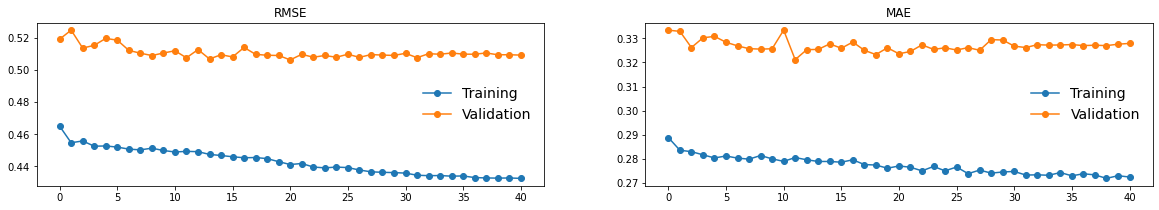

In [23]:
# Create figure
#
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 3) )

# Plot RMSE
#
ax[0].plot( score.history['RMSE'], marker = 'o');
ax[0].plot( score.history['val_RMSE'], marker = 'o');
ax[0].legend(['Training', 'Validation'], frameon = False, fontsize = 14);
ax[0].set_title('RMSE');

# Plot RMSE
#
ax[1].plot( score.history['MAE'], marker = 'o');
ax[1].plot( score.history['val_MAE'], marker = 'o');
ax[1].legend(['Training', 'Validation'], frameon = False, fontsize = 14);
ax[1].set_title('MAE');

## Load optimized model

In [24]:
# Load the best model
#
model.load_weights('models/NBeats_Diff.hdf5')

print('[INFO] Model loaded')

[INFO] Model loaded


## Evaluation

### Get predictions

In [25]:
# Get predictions
#
pred = model.predict( testX )

pred = pred.squeeze(-1)

### Inverse "Lag-d Diff" transformation

In [26]:
for i in range( Horizon ):
    testY[:, i] = test_CurrentValue - testY[:, i]
    pred[:, i]  = test_CurrentValue - pred[:, i]

### Apply inverse scaling/transformation

In [27]:
# Apply inverse scaling
#
for i in range( Horizon ):
    testY[:,  i] = scaler.inverse_transform( testY[:,  i].reshape(-1,1) ).squeeze(-1)
    pred[:, i]   = scaler.inverse_transform( pred[:, i].reshape(-1,1) ).squeeze(-1)


# Apply inverse transformation   
#
if (Transformation == True):
    testY = np.exp( testY ) - VALUE
    pred  = np.exp( pred )  - VALUE

### Calculate Performance on Testing set - Prediction visualization


In [28]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = testY[:,  i]
    Prices['Prediction'] = pred[:, i] 



    # Evaluation
    #
    MAE, RMSE, MAPE, SMAPE, R2 = RegressionEvaluation( Prices )

    # Store results
    #
    Performance_Foresting_Model['RMSE']    += [ RMSE  ]
    Performance_Foresting_Model['MAE']     += [ MAE   ]
    Performance_Foresting_Model['SMAPE']   += [ SMAPE ]
    Performance_Foresting_Model['R2']      += [ R2    ]

#     # Present results
#     #
#     print('Horizon: ', i+1)
#     print('> MAE:   ', MAE)
#     print('> RMSE:  ', RMSE)
#     print('> SMAPE: ', SMAPE)
#     print('> R2:    ', R2)
#     print()
    
    print('Horizon: %2i MAE %5.2f SMAPE: %5.2f R2: %.2f' %(i+1, MAE, SMAPE, R2) )

[INFO] Feature:  PM2.5
------------------------------------------------
Horizon:  1 MAE  0.57 SMAPE: 18.49 R2: 0.73
Horizon:  2 MAE  0.80 SMAPE: 25.82 R2: 0.51
Horizon:  3 MAE  0.92 SMAPE: 30.24 R2: 0.39
Horizon:  4 MAE  1.00 SMAPE: 33.51 R2: 0.31


In [29]:
# PM2.5 - Log+StandardScaler
# ------------------------------------------------
# Horizon:  1 MAE  0.57 SMAPE: 18.50 R2: 0.73
# Horizon:  2 MAE  0.80 SMAPE: 25.85 R2: 0.51
# Horizon:  3 MAE  0.92 SMAPE: 30.35 R2: 0.39
# Horizon:  4 MAE  1.00 SMAPE: 33.45 R2: 0.30


# All data - Log+StandardScaler
# ------------------------------------------------
# Horizon:  1 MAE  0.57 SMAPE: 18.49 R2: 0.73
# Horizon:  2 MAE  0.80 SMAPE: 25.82 R2: 0.51
# Horizon:  3 MAE  0.92 SMAPE: 30.24 R2: 0.39
# Horizon:  4 MAE  1.00 SMAPE: 33.51 R2: 0.31


# PM2.5-PM10 - Log+StandardScaler
# ------------------------------------------------
# Horizon:  1 MAE  0.57 SMAPE: 18.62 R2: 0.73
# Horizon:  2 MAE  0.79 SMAPE: 25.81 R2: 0.52
# Horizon:  3 MAE  0.91 SMAPE: 30.21 R2: 0.39
# Horizon:  4 MAE  1.00 SMAPE: 33.60 R2: 0.31

## Visualization

[INFO] Feature:  PM2.5
------------------------------------------------


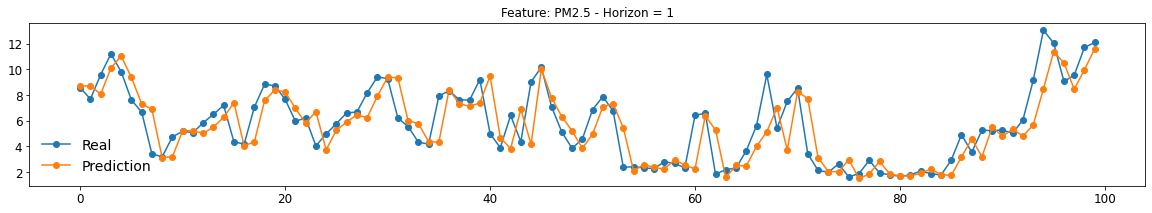

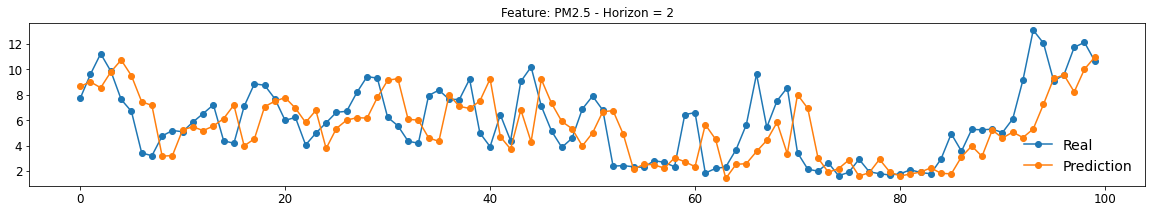

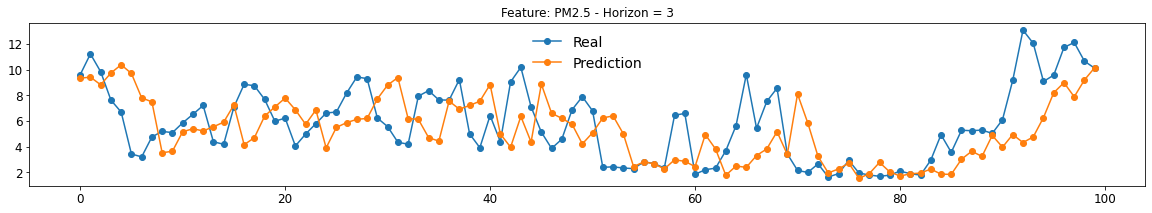

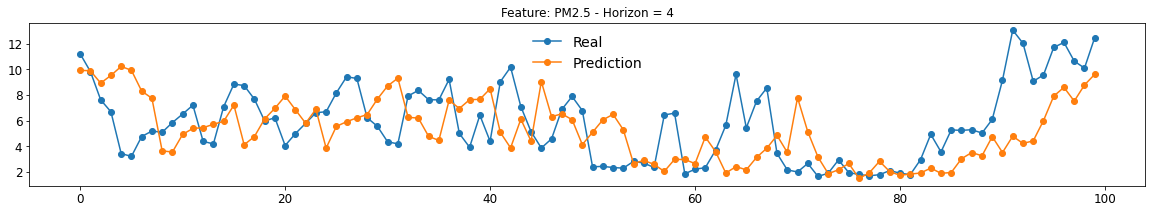

In [30]:
print('[INFO] Feature: ', targetSeries)
print('------------------------------------------------')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = testY[:,  i]
    Prices['Prediction'] = pred[:, i] 
            
    
    # Plot Real & Predicted values
    #
    Prices[:100].plot( figsize = (20, 3), marker = 'o' )
    #
    plt.title('Feature: {} - Horizon = {}'.format(targetSeries, i+1))
    plt.legend( frameon = False, fontsize = 14)
    plt.xticks(size = 12)
    plt.yticks(size = 12)
    plt.show()        

## Residual analysis

[INFO] Feature:  PM2.5
--------------------------------------------------


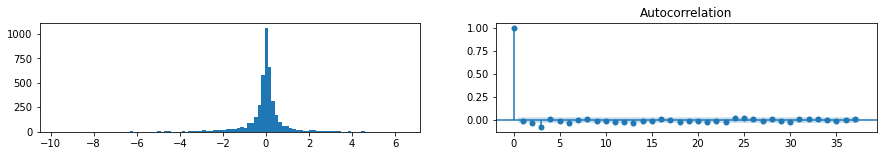

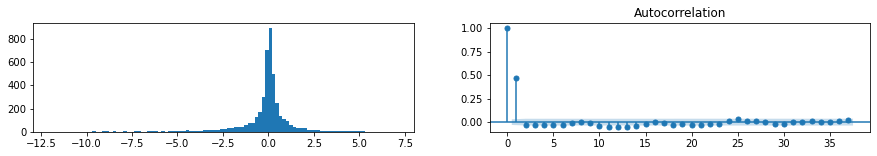

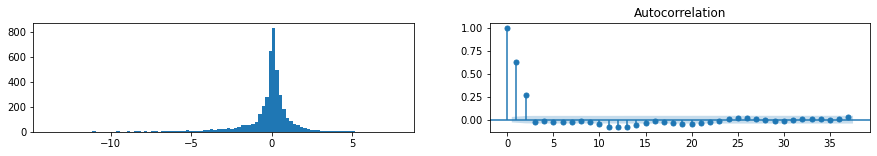

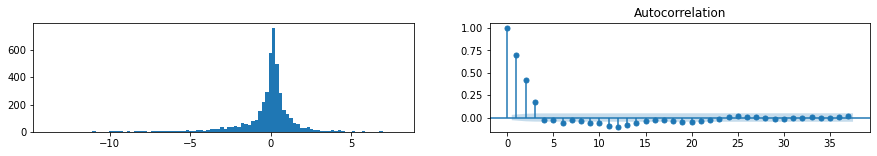

In [31]:
print('[INFO] Feature: ', targetSeries)
print(50 * '-')
Performance_Foresting_Model = {'RMSE': [], 'MAE': [], 'SMAPE': [], 'R2' : []}

for i in range( Horizon ):

    Prices = pd.DataFrame([])        

    Prices['Real']       = testY[:,  i]
    Prices['Prediction'] = pred[:, i] 


            
    from scipy import stats
    from statsmodels.graphics.tsaplots import plot_acf
    
    res = (Prices['Prediction'] - Prices['Real']).to_numpy()
    
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 2) )

    ax[0].hist( res, bins = 100 )    
    plot_acf( res, ax=ax[1] )      

## Examples

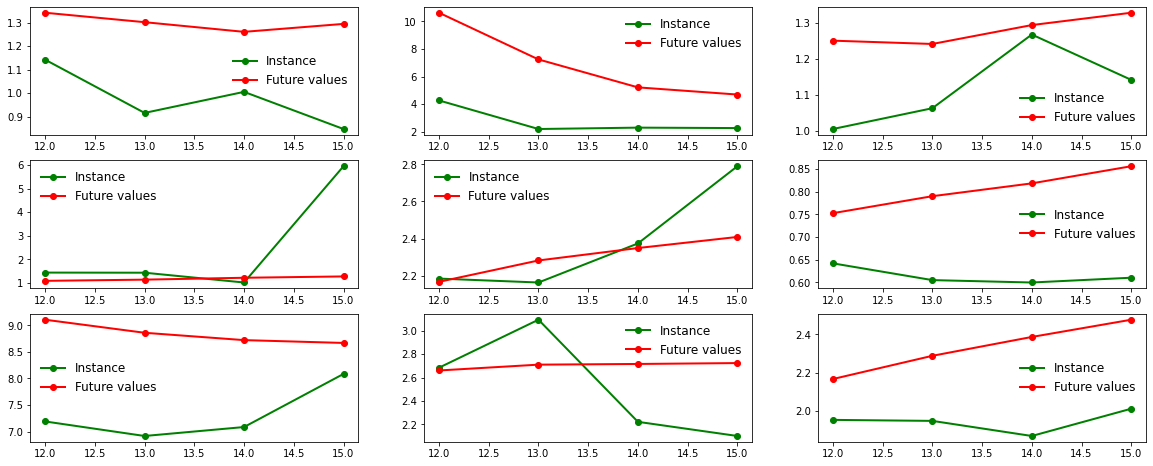

In [32]:
subplots = [331, 332, 333, 334, 335, 336,  337, 338, 339]
plt.figure( figsize = (20, 8) )
RandomInstances = [random.randint(1, testY.shape[0]) for i in range(0, 9)]

for plot_id, i in enumerate(RandomInstances):

    plt.subplot(subplots[plot_id])
    #
    plt.plot(range(Lag, Lag + Horizon), testY[i], color='g', marker = 'o', linewidth = 2)
    plt.plot(range(Lag, Lag + Horizon), pred[i],  color='r', marker = 'o', linewidth = 2)

    plt.legend(['Instance', 'Future values', 'Prediction'], frameon = False, fontsize = 12)
plt.show()

# Store predictions

In [33]:
Outputs = pd.DataFrame( [] )


Outputs[ targetSeries ] = testY.flatten()
Outputs['NBeats_diff'] = pred.flatten()

Outputs.to_csv('Predictions/NBeats_diff.csv')